In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Bidirectional Associative Memory(BAM)

In [2]:
class BAM:
  n = None
  m = None
  W = None
  def __init__(self, n, m):
    self.m = m
    self.n = n
    self.W = np.zeros((n,m)) 

  def fit(self, X_list, Y_list):
    for i in range(len(X_list)):
      self.W += np.multiply(X_list[i], Y_list[i].T)
    
  def predictOutput(self, X):
    Y = np.dot(self.W.T, X)
    Y[Y < 0] = -1
    Y[Y >= 0] = 1
    return np.array(Y)

  def predictInput(self, Y):
    Y = np.dot(self.W, Y)
    Y[Y < 0] = -1
    Y[Y >= 0] = 1
    return np.array(Y)

In [3]:
X_list = [
      np.array([1, 1, 1, 1, 1, 1 ]),
      np.array([-1, -1, -1, -1, -1, -1 ]),
      np.array([1, -1, -1, 1, 1, 1 ]),
      np.array([1, 1, -1, -1, -1, -1 ])
]
Y_list = [
      np.array([1, 1, 1]),
      np.array([-1, -1, -1]),
      np.array([-1, 1, 1]),
      np.array([1, -1, 1])          
]

In [4]:
n = X_list[0].shape[0]
m = Y_list[0].shape[0]

for i in range(len(X_list)):
  X_list[i] = X_list[i].reshape(n, 1)
for i in range(len(Y_list)):
  Y_list[i] = Y_list[i].reshape(m, 1)

bam_model = BAM(n, m)
bam_model.fit(X_list, Y_list)
print("The model's energy matrix, W is:")
print(bam_model.W)
print()
print('TEST RESULTS:')
print('Predicting outputs from inputs:')
for X in X_list:
  print(f'Input : {X.T}')
  print(f'Predicted Output : { bam_model.predictOutput(X).T }')
  print()

print('Predicting inputs from outputs:')
for Y in Y_list:
  print(f'Output : {Y.T}')
  print(f'Predicted Input : { bam_model.predictInput(Y).T }')
  print()


The model's energy matrix, W is:
[[2. 2. 4.]
 [4. 0. 2.]
 [2. 2. 0.]
 [0. 4. 2.]
 [0. 4. 2.]
 [0. 4. 2.]]

TEST RESULTS:
Predicting outputs from inputs:
Input : [[1 1 1 1 1 1]]
Predicted Output : [[1. 1. 1.]]

Input : [[-1 -1 -1 -1 -1 -1]]
Predicted Output : [[-1. -1. -1.]]

Input : [[ 1 -1 -1  1  1  1]]
Predicted Output : [[-1.  1.  1.]]

Input : [[ 1  1 -1 -1 -1 -1]]
Predicted Output : [[ 1. -1.  1.]]

Predicting inputs from outputs:
Output : [[1 1 1]]
Predicted Input : [[1. 1. 1. 1. 1. 1.]]

Output : [[-1 -1 -1]]
Predicted Input : [[-1. -1. -1. -1. -1. -1.]]

Output : [[-1  1  1]]
Predicted Input : [[ 1. -1.  1.  1.  1.  1.]]

Output : [[ 1 -1  1]]
Predicted Input : [[ 1.  1.  1. -1. -1. -1.]]



It is observed from the above tests that the level of weight corrections of the BAM to be done is less.

In [5]:
print('Predicting for unseen samples and levels of weight corrections:')
X_ec = np.array([1, -1, 1, -1, 1, -1]).reshape(n,1)
Y_ec = bam_model.predictOutput(X_ec)
print(f'Error correction sample : {X_ec.T}')
print(f'Output : {Y_ec.T}')
print(f'Predicted Input : { bam_model.predictInput(Y_ec).T }')
print()

Predicting for unseen samples and levels of weight corrections:
Error correction sample : [[ 1 -1  1 -1  1 -1]]
Output : [[1. 1. 1.]]
Predicted Input : [[1. 1. 1. 1. 1. 1.]]



# Self Organizing Neural Network

In [6]:
class SONN:
  def __init__(self, n, m, sigma = 1, alpha = 0.1, n_epochs = 2000, decay_param = 1000):
    self.n = n
    self.m = m
    self.sigma = sigma
    self.alpha = alpha
    self.n_epochs = n_epochs
    self.decay_param = decay_param 

    self.A = np.zeros((n, m))
    self.W = np.random.ranf((n, m, 2)) - 0.5
    self.W =  2 * self.W
    self.neighbour_x = np.arange(n)
    self.neighbour_y = np.arange(m)
  
  def fit(self, input_data):
    for epoch in tqdm(range(1, self.n_epochs + 1)):
      np.random.shuffle(input_data)
      idx = np.random.randint(0, input_data.shape[0])
      win_neuron = self.getWinnerNeuron(input_data[idx])
      self.updateWeights(win_neuron, input_data[idx], epoch)
      
      if epoch%500 == 0:
        plot_x = []
        plot_y = []
      
        for i in range(self.W.shape[0]):
          for j in range(self.W.shape[1]):
            plot_x.append(self.W[i][j][0])
            plot_y.append(self.W[i][j][1])
      
        plt.title('After ' + str(epoch) + ' iterations')
        plt.scatter(plot_x, plot_y, c = 'r')
        plt.show()
        plt.close()

  def updateWeights(self, win_neuron, inputx, iteration):
    alpha_new, sigma_new = self.getAlphaAndSigma(iteration)
    d = 2 * np.pi * (sigma_new**2)
    ax = np.exp(-1 * np.square(self.neighbour_x - win_neuron[0]) / d)
    ay = np.exp(-1 * np.square(self.neighbour_y - win_neuron[1]) / d)
    
    neighborhood = np.outer(ax, ay)
    
    cursor = np.nditer(neighborhood, flags = ['multi_index'])
    while not cursor.finished:
        self.W[cursor.multi_index] += alpha_new * neighborhood[cursor.multi_index] * (inputx - self.W[cursor.multi_index])
        cursor.iternext()
    
  def getWinnerNeuron(self, X):
    s = X - self.W
    tmp = np.nditer(self.A, flags =['multi_index'])
    while not tmp.finished:
      self.A[tmp.multi_index] = np.linalg.norm(s[tmp.multi_index])  
      tmp.iternext()
    return np.unravel_index(self.A.argmin(), self.A.shape)

  def getAlphaAndSigma(self, iteration):
    denum = (1 + iteration / self.decay_param)
    alpha_new = self.alpha/ denum
    sigma_new = self.sigma / denum
    return alpha_new, sigma_new

  def testandDisplay(self, X):
    print(f'For input {X}:')
    win_neuron = self.getWinnerNeuron(X)
    plot_x = np.arange(-1, 1, 0.1)
    plot_y = np.arange(-1, 1, 0.1)
    x_grid, y_grid = np.meshgrid(plot_x, plot_y)
    
    x, y = self.W[win_neuron[0]][win_neuron[1]][0], self.W[win_neuron[0]][win_neuron[1]][1]
    dist = math.sqrt((x - X[0])**2 + (y - X[1])**2)
    x = round(x, 1)
    y = round(y, 1)
    
    print(f'Distance:{dist}')
    print(f'Visually in the network:')
    plt.title(f"For {X}. distance = {str(dist)}")
    plt.scatter(x_grid, y_grid, c = 'b')
    plt.scatter(x, y, c = 'r')
    plt.show()
    plt.close()
    

In [7]:
from tqdm.notebook import tqdm
# 1500 random vectors as input data
X_train = np.random.uniform(-1, 1, (1500, 2))

In [8]:
X_val_list = [
    np.array([0.1,  0.8]),
    np.array([0.5,  -0.2]),
    np.array([-0.8,  -0.9]),
    np.array([-0.6,  0.9])        
]

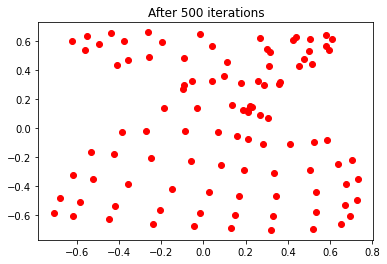

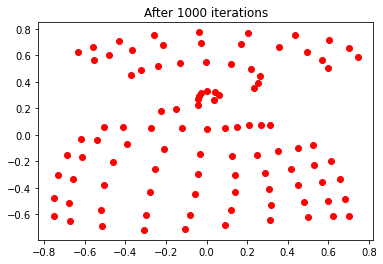

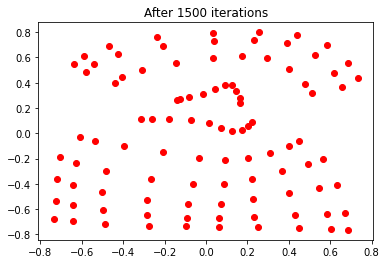

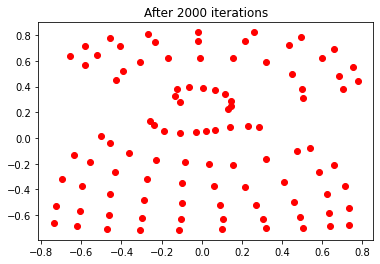

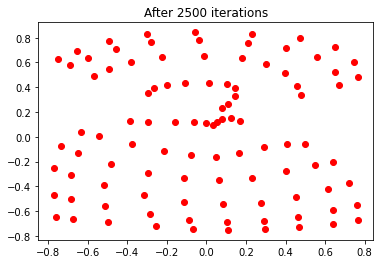

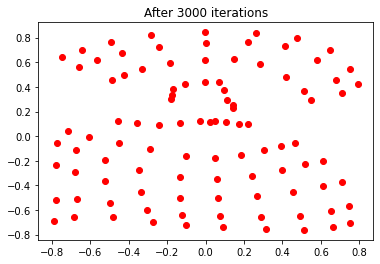

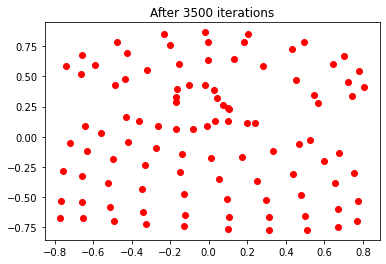

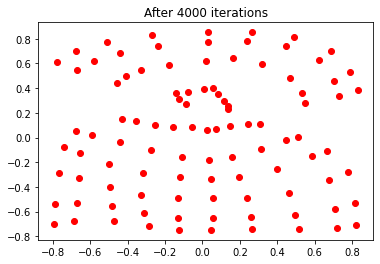

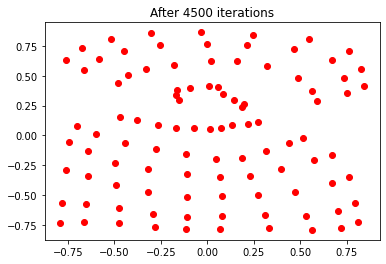

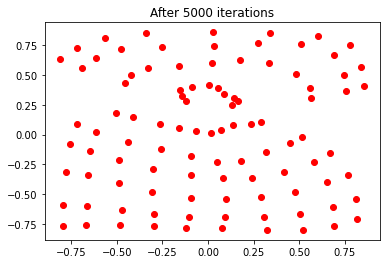

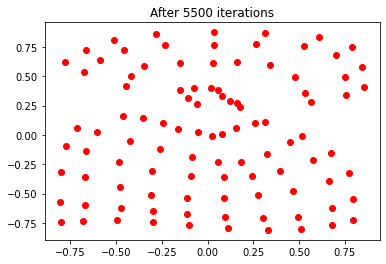

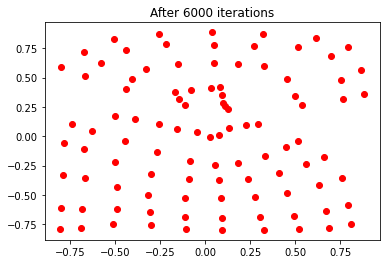

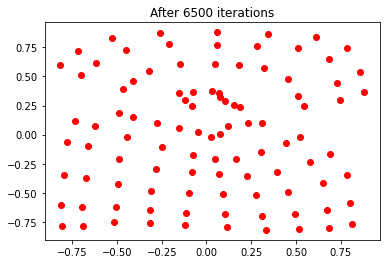

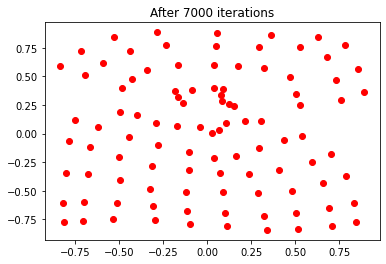

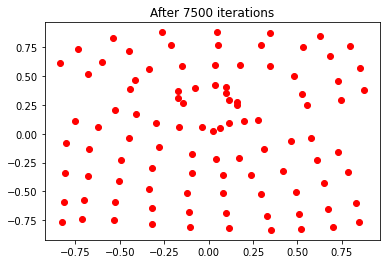

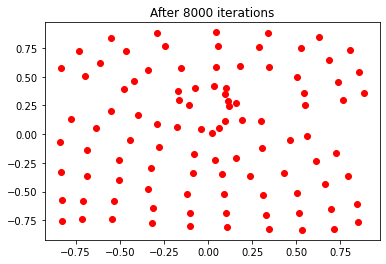

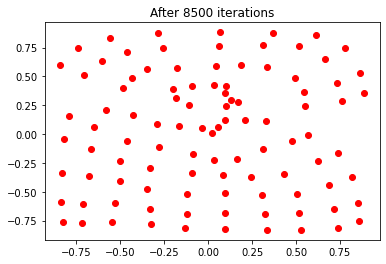

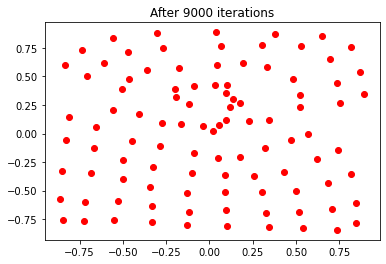

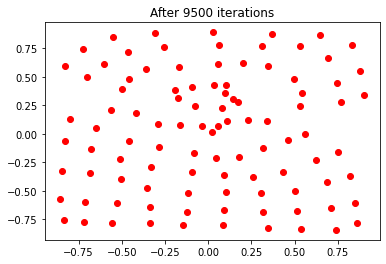

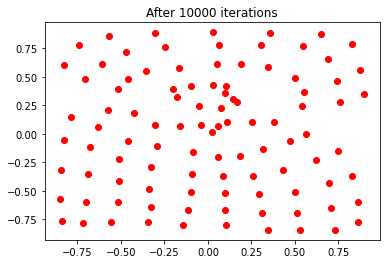

In [9]:
sonn_model = SONN(10, 10, n_epochs = 10000, decay_param=5000)
sonn_model.fit(X_train)


For input [0.1 0.8]:
Distance:0.03983985744779095
Visually in the network:


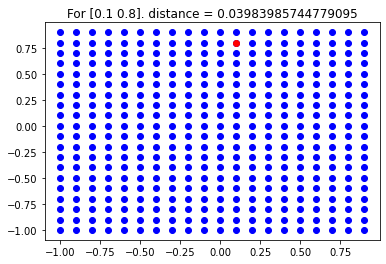

In [10]:
sonn_model.testandDisplay(X_val_list[0])

For input [ 0.5 -0.2]:
Distance:0.12361128936304686
Visually in the network:


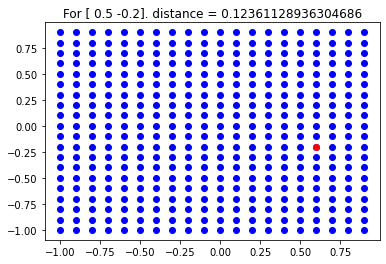

In [11]:
sonn_model.testandDisplay(X_val_list[1])

For input [-0.8 -0.9]:
Distance:0.13947500140034397
Visually in the network:


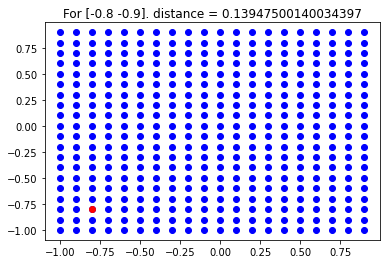

In [12]:
sonn_model.testandDisplay(X_val_list[2])

For input [-0.6  0.9]:
Distance:0.051640287124517216
Visually in the network:


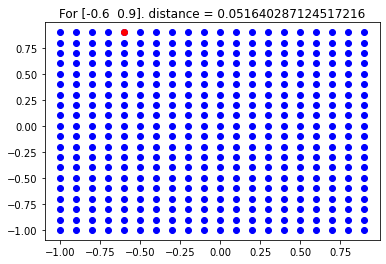

In [13]:
sonn_model.testandDisplay(X_val_list[3])

### References
1. https://www.philadelphia.edu.jo/academics/qhamarsheh/uploads/Lecture%2013%20-Supervised%20Learning%20_Bidirectional%20associative%20memory(BAM).pdf
2. https://www.geeksforgeeks.org/ann-implementation-of-self-organizing-neural-network-sonn-from-scratch/